# A Simple ML Model for Predicting Exoplanet Discovery Methods

## Introduction

#### Hello! This notebook demos a simple KNN clustering model, which predicts how a given exoplanet was discovered. 

#### The Milky Way is chock-full of "exoplanets" - planets that orbit stars other than the sun. While exoplanets are generally too miniscule for even advanced telescopic technology to detect, astronmers have devised several methods for locating them. NASA and its partners collect the fruits of these efforts at https://exoplanetarchive.ipac.caltech.edu/. 

#### In this notebook, I analyze that data and use a KNN model to look for blindspots in the data collection efforts. The basic hypothesis is this: if a simple machine learning model can accurately predict how an exoplanet was discovered by considering the recorded features of the planet (e.g., mass, density), the methods of discovering exoplanets may each have unique shortcomings. These shortcomings, in turn, may necessitate applying multiple discovery methods to fully catalouge exoplanets.

## Exploratory Data Analysis

#### At this stage, the goal is to understand our data and find candidates for model features.

In [1]:
#%pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import pandasql
from pandasql import sqldf
import scipy
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import collections
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import astropy
from astropy import units as  u
import mw_plot
from mw_plot import MWSkyMap

In [3]:
df = pd.read_csv(r'C:\Users\lomba\Downloads\ps.csv')

In [4]:
df.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,5/14/2014,2008-01,5/14/2014
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,7/23/2014,2011-08,7/23/2014
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,4/25/2018,2009-10,5/14/2014
3,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,4/25/2018,2011-08,7/23/2014
4,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,9/4/2018,2017-03,9/6/2018


In [5]:
df.shape

(33358, 92)

#### We'll want to take a look for null values. 

In [6]:
pd.set_option('display.max_rows',92)
df.isna().sum()

pl_name                0
hostname               0
default_flag           0
sy_snum                0
sy_pnum                0
discoverymethod        0
disc_year              0
disc_facility          0
soltype                0
pl_controv_flag        0
pl_refname             0
pl_orbper           2834
pl_orbpererr1       4086
pl_orbpererr2       4087
pl_orbperlim        2833
pl_orbsmax         14919
pl_orbsmaxerr1     28909
pl_orbsmaxerr2     28910
pl_orbsmaxlim      12214
pl_rade            10067
pl_radeerr1        10711
pl_radeerr2        10711
pl_radelim          7396
pl_radj            22899
pl_radjerr1        23499
pl_radjerr2        23499
pl_radjlim         22899
pl_bmasse          28388
pl_bmasseerr1      28834
pl_bmasseerr2      28834
pl_bmasselim       28388
pl_bmassj          28389
pl_bmassjerr1      28840
pl_bmassjerr2      28840
pl_bmassjlim       28389
pl_bmassprov       28388
pl_orbeccen        16480
pl_orbeccenerr1    30558
pl_orbeccenerr2    30559
pl_orbeccenlim     13808


#### Let's make sure that our target variable doesn't contain any nulls.

In [7]:
p = sqldf("SELECT COUNT(pl_name) FROM df WHERE discoverymethod=False", globals())
p

,COUNT(pl_name)
0,0


#### A visual inspection of the dataset reveals that it's riddled with null values - the code below isolates features with ~10% nulls.

In [8]:
z = df.isna().sum()
z = pd.DataFrame(z).reset_index()
z.columns = ['colname', 'nancount']
variables = sqldf("SELECT * FROM z WHERE nancount BETWEEN 1 AND 3300", globals())
variables = pd.DataFrame(variables)
variables

,colname,nancount
0,pl_orbper,2834
1,pl_orbperlim,2833
2,st_teff,2053
3,st_tefferr1,2738
4,st_tefferr2,2978
5,st_tefflim,2053
6,st_rad,1932
7,st_radlim,1932
8,sy_dist,792
9,sy_disterr1,1612


#### Next, we check to see if these attributes have any significant correlation. We premptively drop the "error" columns. Those columns record the margin of error of a particular estimate. Consequently, they're (a) unlikely to become features and (b) likley to be correlated to the attributes whose error they measure.

In [9]:
cn = list(variables['colname'])
cn = df[cn]
cn = pd.DataFrame(cn)
corrm = cn.corr()
corrm = pd.DataFrame(corrm)
corrm = corrm.drop(['st_tefferr1', 'st_tefferr2', 'sy_disterr1', 'sy_disterr2', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_kmagerr1', 'sy_kmagerr2', 'sy_gaiamagerr1', 'sy_gaiamagerr2'], axis=1)
corrm = corrm.drop(['st_tefferr1', 'st_tefferr2', 'sy_disterr1', 'sy_disterr2', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_kmagerr1', 'sy_kmagerr2', 'sy_gaiamagerr1', 'sy_gaiamagerr2'], axis=0)
corrm.style.background_gradient(cmap='Reds', axis=0)

C:\Users\lomba\AppData\Local\Temp\ipykernel_5648\2568493060.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrm = cn.corr()


,pl_orbper,pl_orbperlim,st_teff,st_tefflim,st_rad,st_radlim,sy_dist,sy_vmag,sy_kmag,sy_gaiamag
pl_orbper,1.000000,0.000041,-0.012606,-0.000036,-0.002596,nan,-0.007977,-0.006144,-0.012973,-0.008309
pl_orbperlim,0.000041,1.000000,0.002783,0.000052,0.000900,nan,0.010731,0.014105,0.015021,0.015012
st_teff,-0.012606,0.002783,1.000000,-0.005458,0.045009,-0.020885,0.298577,-0.167087,0.079576,-0.118693
st_tefflim,-0.000036,0.000052,-0.005458,1.000000,nan,nan,0.005783,nan,nan,nan
st_rad,-0.002596,0.000900,0.045009,nan,1.000000,-0.004535,0.013206,-0.294965,-0.283200,-0.286218
st_radlim,nan,nan,-0.020885,nan,-0.004535,1.000000,-0.009748,0.016290,0.002859,0.011743
sy_dist,-0.007977,0.010731,0.298577,0.005783,0.013206,-0.009748,1.000000,0.570860,0.686829,0.591660
sy_vmag,-0.006144,0.014105,-0.167087,nan,-0.294965,0.016290,0.570860,1.000000,0.943827,0.994673
sy_kmag,-0.012973,0.015021,0.079576,nan,-0.283200,0.002859,0.686829,0.943827,1.000000,0.968183
sy_gaiamag,-0.008309,0.015012,-0.118693,nan,-0.286218,0.011743,0.591660,0.994673,0.968183,1.000000


#### Two of the attributes don't overlap at all. Let's drop them as well. 

In [10]:
corrm = corrm.drop(['st_radlim', 'st_tefflim'], axis=1)
corrm = corrm.drop(['st_radlim', 'st_tefflim'], axis=0)
corrm.style.background_gradient(cmap='Reds', axis=0)

,pl_orbper,pl_orbperlim,st_teff,st_rad,sy_dist,sy_vmag,sy_kmag,sy_gaiamag
pl_orbper,1.000000,0.000041,-0.012606,-0.002596,-0.007977,-0.006144,-0.012973,-0.008309
pl_orbperlim,0.000041,1.000000,0.002783,0.000900,0.010731,0.014105,0.015021,0.015012
st_teff,-0.012606,0.002783,1.000000,0.045009,0.298577,-0.167087,0.079576,-0.118693
st_rad,-0.002596,0.000900,0.045009,1.000000,0.013206,-0.294965,-0.283200,-0.286218
sy_dist,-0.007977,0.010731,0.298577,0.013206,1.000000,0.570860,0.686829,0.591660
sy_vmag,-0.006144,0.014105,-0.167087,-0.294965,0.570860,1.000000,0.943827,0.994673
sy_kmag,-0.012973,0.015021,0.079576,-0.283200,0.686829,0.943827,1.000000,0.968183
sy_gaiamag,-0.008309,0.015012,-0.118693,-0.286218,0.591660,0.994673,0.968183,1.000000


#### Now, we turn to attributes without any null values.

In [11]:
z = df.isna().sum()
z = pd.DataFrame(z).reset_index()
z.columns = ['colname', 'nancount']
variables2 = sqldf("SELECT * FROM z WHERE nancount = 0", globals())
variables2 = pd.DataFrame(variables2)
variables2

,colname,nancount
0,pl_name,0
1,hostname,0
2,default_flag,0
3,sy_snum,0
4,sy_pnum,0
5,discoverymethod,0
6,disc_year,0
7,disc_facility,0
8,soltype,0
9,pl_controv_flag,0


#### Without diving into too much detail - most of the features without a null value are too closely related to our target variable for our purposes. For example 'disc_facility' records which facility discovered which exoplanets. But because certain facilties likely use only one or two methods for discovering exoplanets (as the pivot table below confirms), the predicitve "signal" of the facility would likely drown out any "signal" in the recorded attributes of the exoplanets. 

In [12]:
pt = pd.pivot_table(df, values = 'pl_name', index = ['disc_facility', 'discoverymethod'])
pt.head(20)

C:\Users\lomba\AppData\Local\Temp\ipykernel_5648\1158170526.py:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pt = pd.pivot_table(df, values = 'pl_name', index = ['disc_facility', 'discoverymethod'])


Empty DataFrame
Columns: []
Index: [(Acton Sky Portal Observatory, Transit), (Anglo-Australian Telescope, Radial Velocity), (Anglo-Australian Telescope, Transit), (Apache Point Observatory, Radial Velocity), (Arecibo Observatory, Pulsar Timing), (Atacama Large Millimeter Array (ALMA), Disk Kinematics), (Bohyunsan Optical Astronomical Observatory, Radial Velocity), (CHaracterising ExOPlanets Satellite (CHEOPS), Transit), (Calar Alto Observatory, Radial Velocity), (Cerro Tololo Inter-American Observatory, Imaging), (Cerro Tololo Inter-American Observatory, Radial Velocity), (Cerro Tololo Inter-American Observatory, Transit), (CoRoT, Radial Velocity), (CoRoT, Transit), (European Southern Observatory, Imaging), (European Southern Observatory, Radial Velocity), (European Space Agency (ESA) Gaia Satellite, Transit), (Fred Lawrence Whipple Observatory, Radial Velocity), (Gemini Observatory, Imaging), (HATNet, Transit)]

#### The only two useful features are 'sy_snum' and 'sy_pnum'. They measure, respectively, the number of stars in an exoplanet's stellar system and the number of other exoplanets in that system.

#### To get a better understanding of the story of exoplanet discovery, let's look at discovery over the years. The chart below plots the year an exoplanet discovery on the x-axis, and its distance from earth (in parsecs) on the y-axis. The marker's size reflects how many other planets are in the exoplanets's system, and the color reflects the exoplanet's method of discovery.

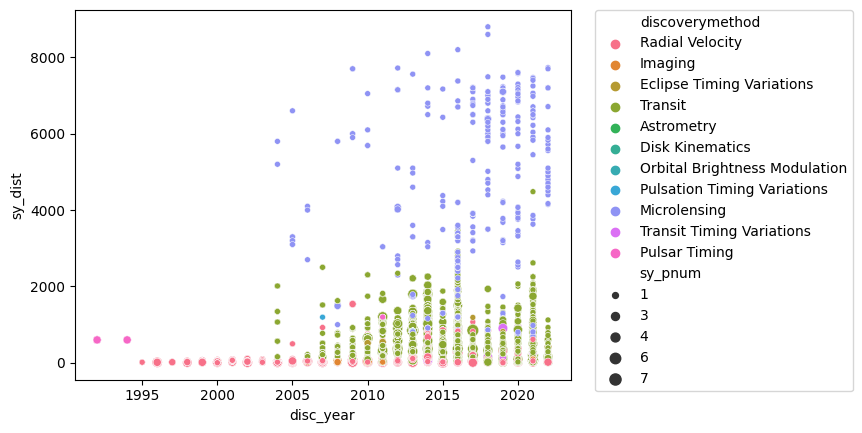

In [13]:
sns.scatterplot(data=df, x="disc_year", y="sy_dist", size="sy_pnum", hue="discoverymethod")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

#### Right off the bat, we can see that three discovery methods - Radial Velocity, Transit, and Microlensing - dominate the dataset. And that we've gotten better at finding distant exoplanets as time goes on. 

#### We'll also break down our chart by discovery method in a relplot.

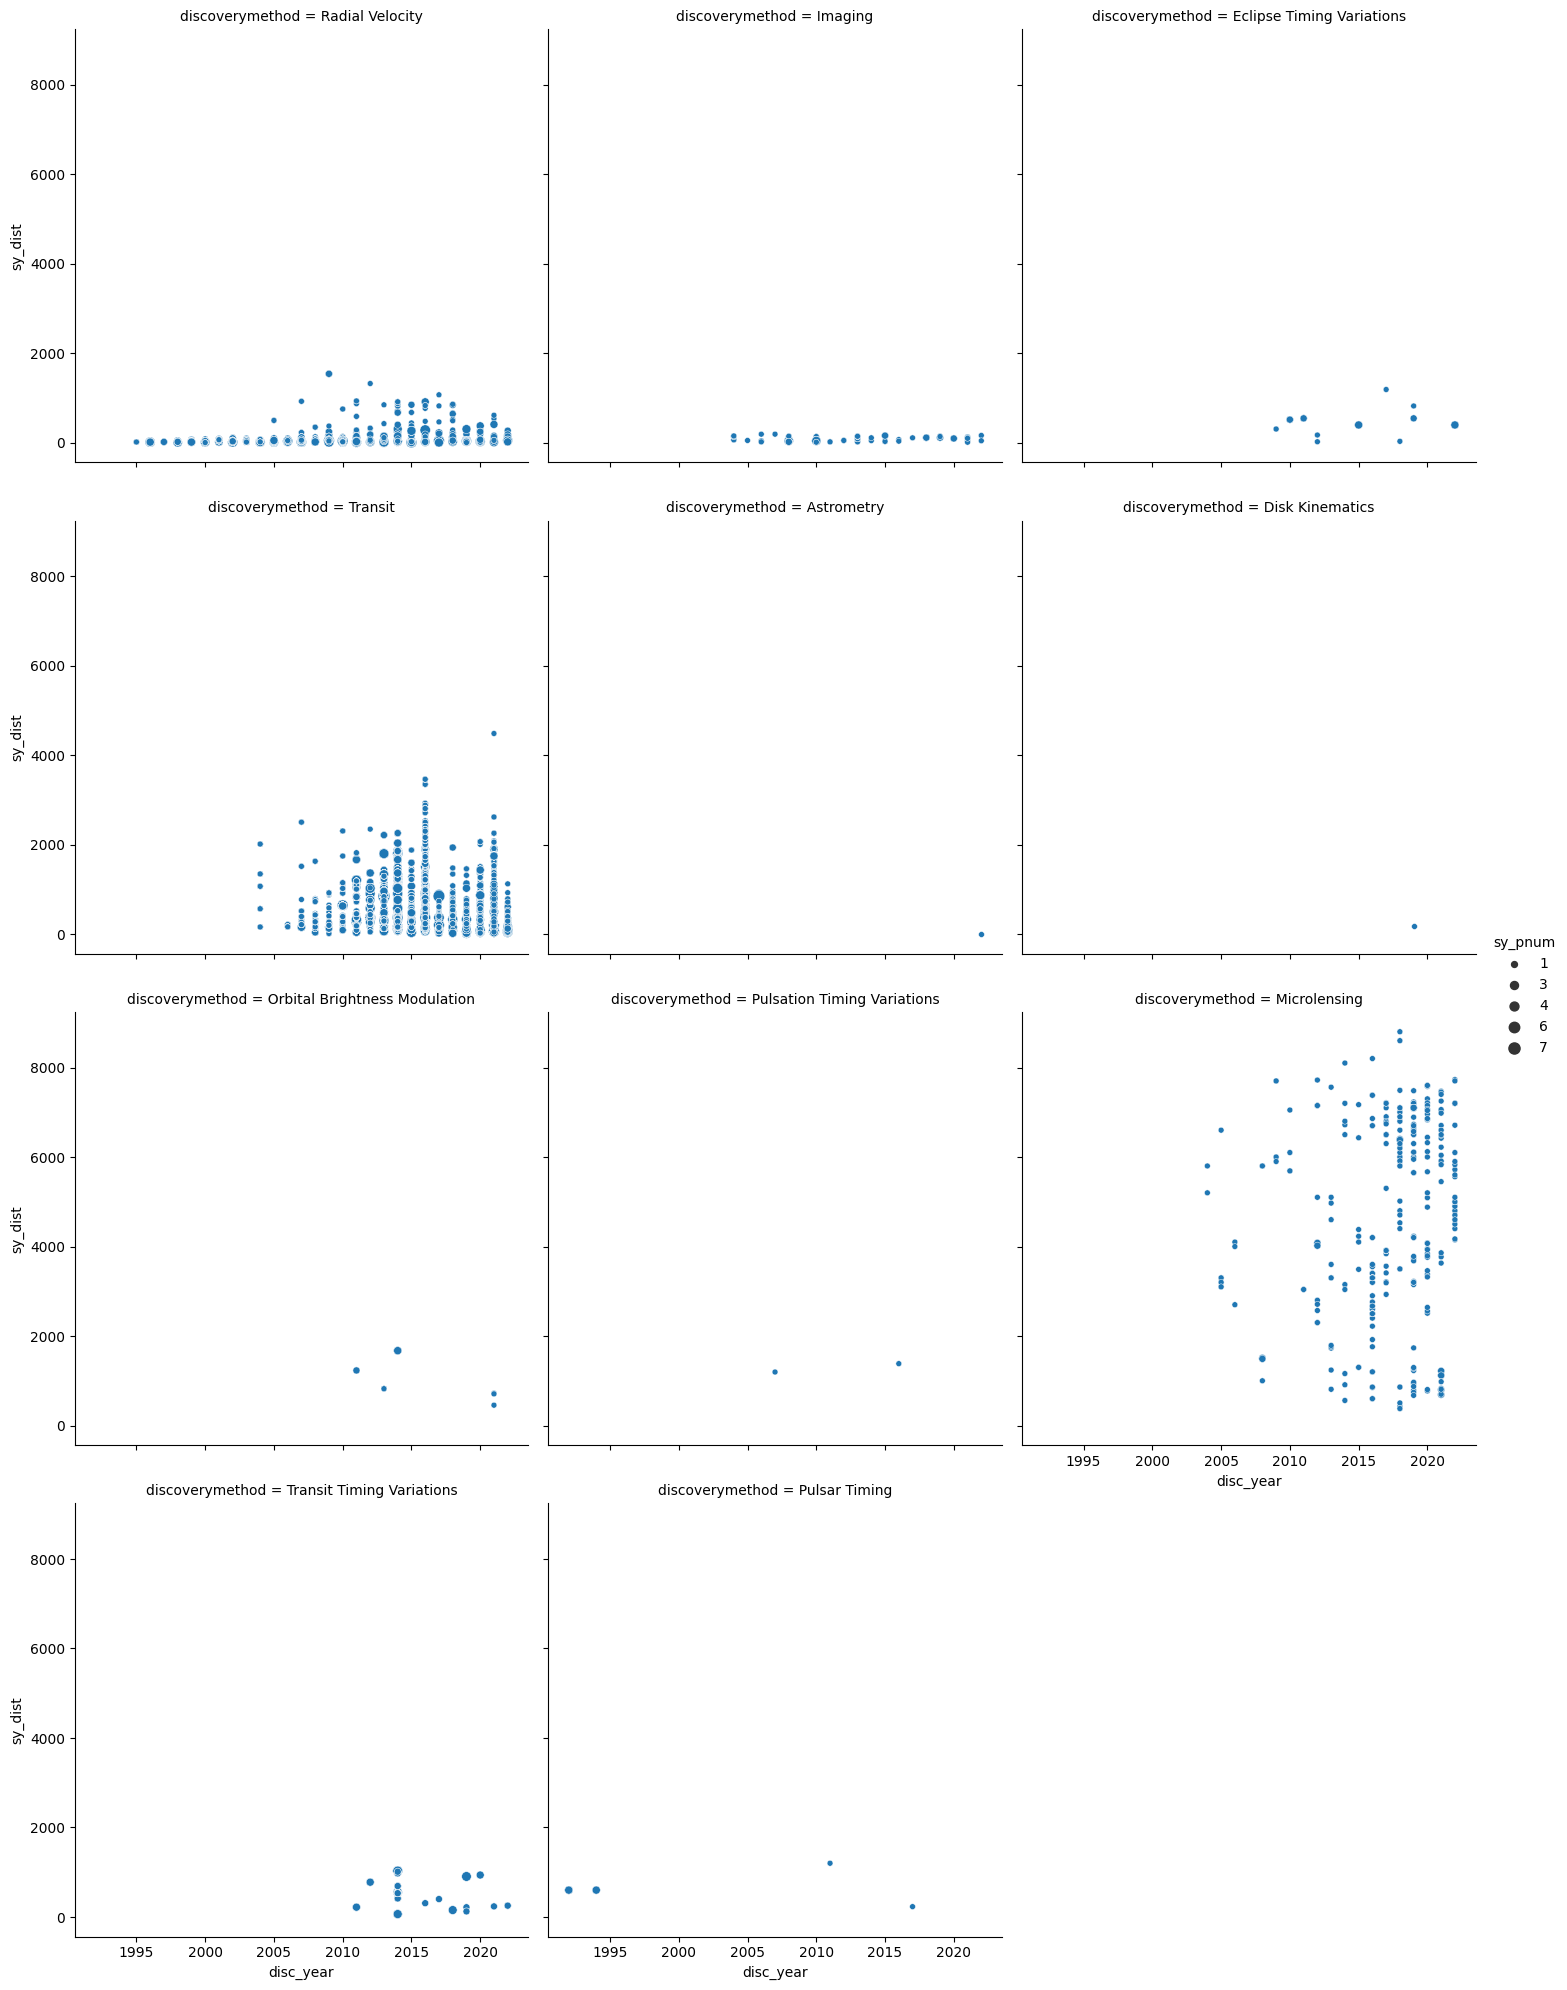

In [14]:
sns.relplot(data=df, x="disc_year", y="sy_dist", size="sy_pnum", col="discoverymethod", col_wrap=3)
plt.show()

#### Let's create some boxcharts and histograms of the candidates for features.

<AxesSubplot: xlabel='sy_snum'>

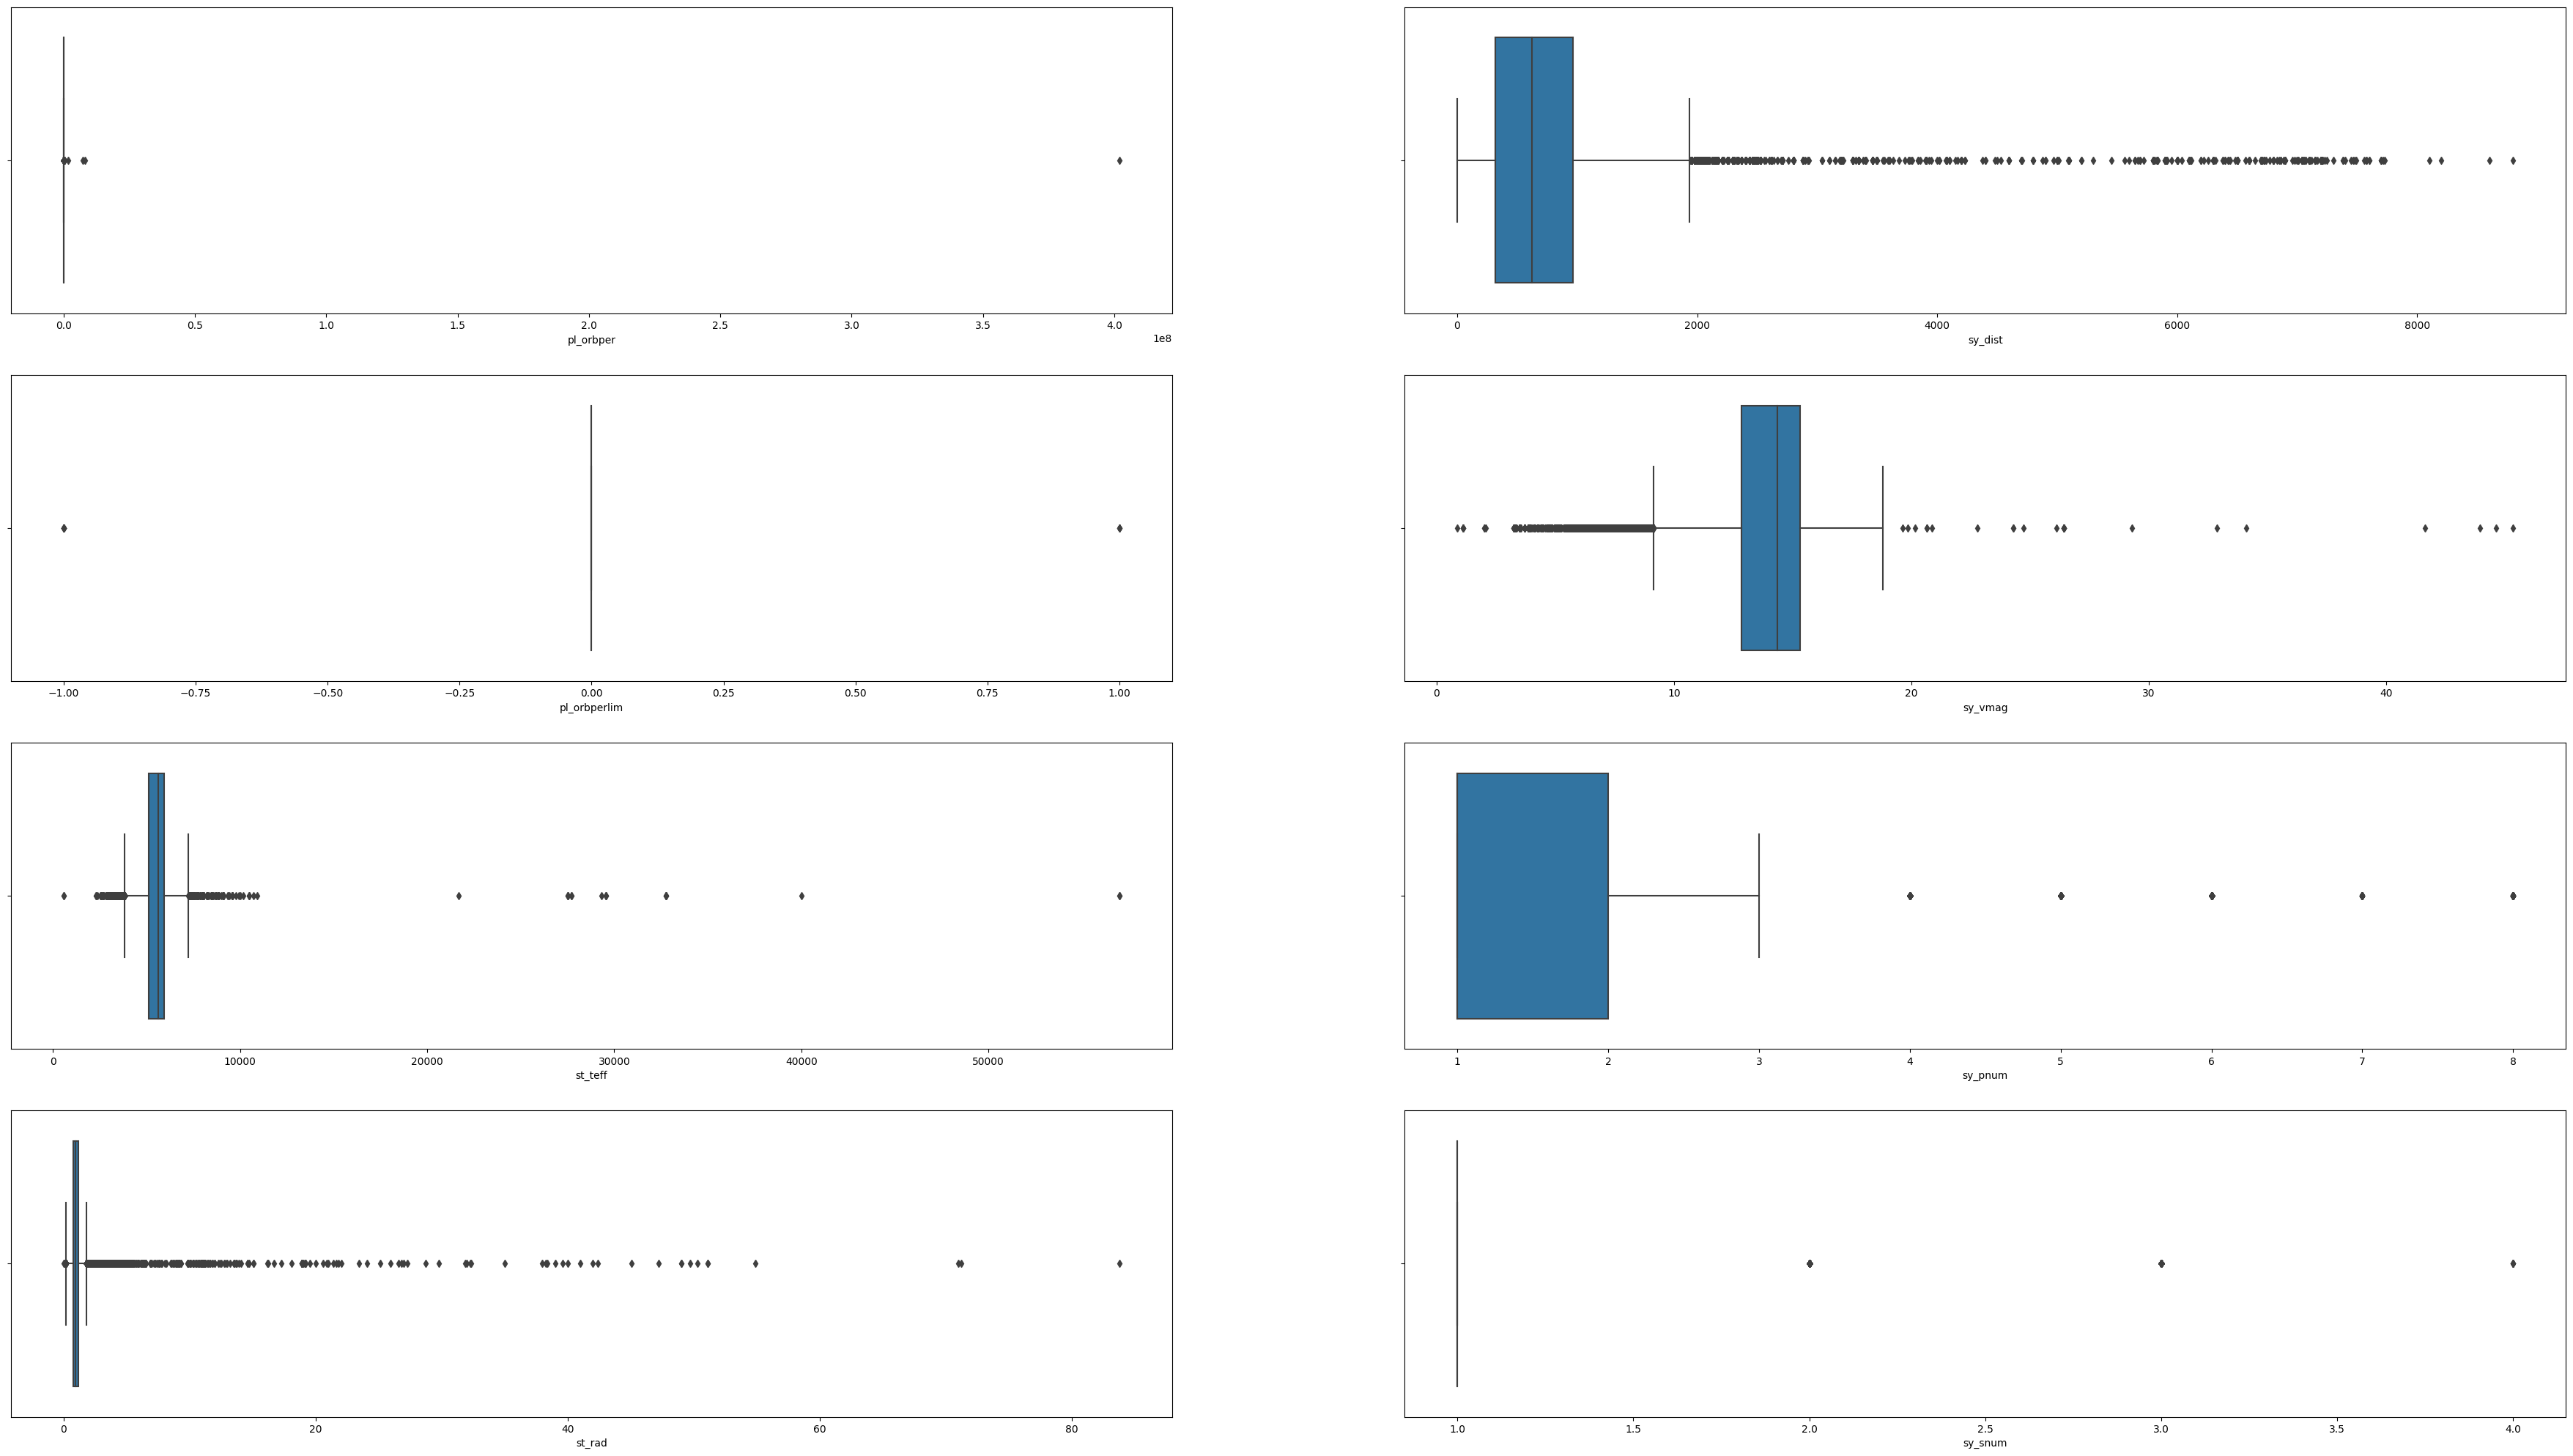

In [15]:
%matplotlib inline
fig, axes = plt.subplots(4, 2, figsize=(45, 25), sharey=False)

sns.boxplot(ax=axes[0, 0], data=df, x='pl_orbper')
sns.boxplot(ax=axes[1, 0], data=df, x='pl_orbperlim')
sns.boxplot(ax=axes[2, 0], data=df, x='st_teff')
sns.boxplot(ax=axes[3, 0], data=df, x='st_rad')
sns.boxplot(ax=axes[0, 1], data=df, x='sy_dist')
sns.boxplot(ax=axes[1, 1], data=df, x='sy_vmag')
sns.boxplot(ax=axes[2, 1], data=df, x='sy_pnum')
sns.boxplot(ax=axes[3, 1], data=df, x='sy_snum')

array([[<AxesSubplot: title={'center': 'pl_orbper'}>,
        <AxesSubplot: title={'center': 'pl_orbperlim'}>,
        <AxesSubplot: title={'center': 'st_teff'}>],
       [<AxesSubplot: title={'center': 'st_rad'}>,
        <AxesSubplot: title={'center': 'sy_dist'}>,
        <AxesSubplot: title={'center': 'sy_vmag'}>],
       [<AxesSubplot: title={'center': 'sy_pnum'}>,
        <AxesSubplot: title={'center': 'sy_snum'}>, <AxesSubplot: >]],
      dtype=object)

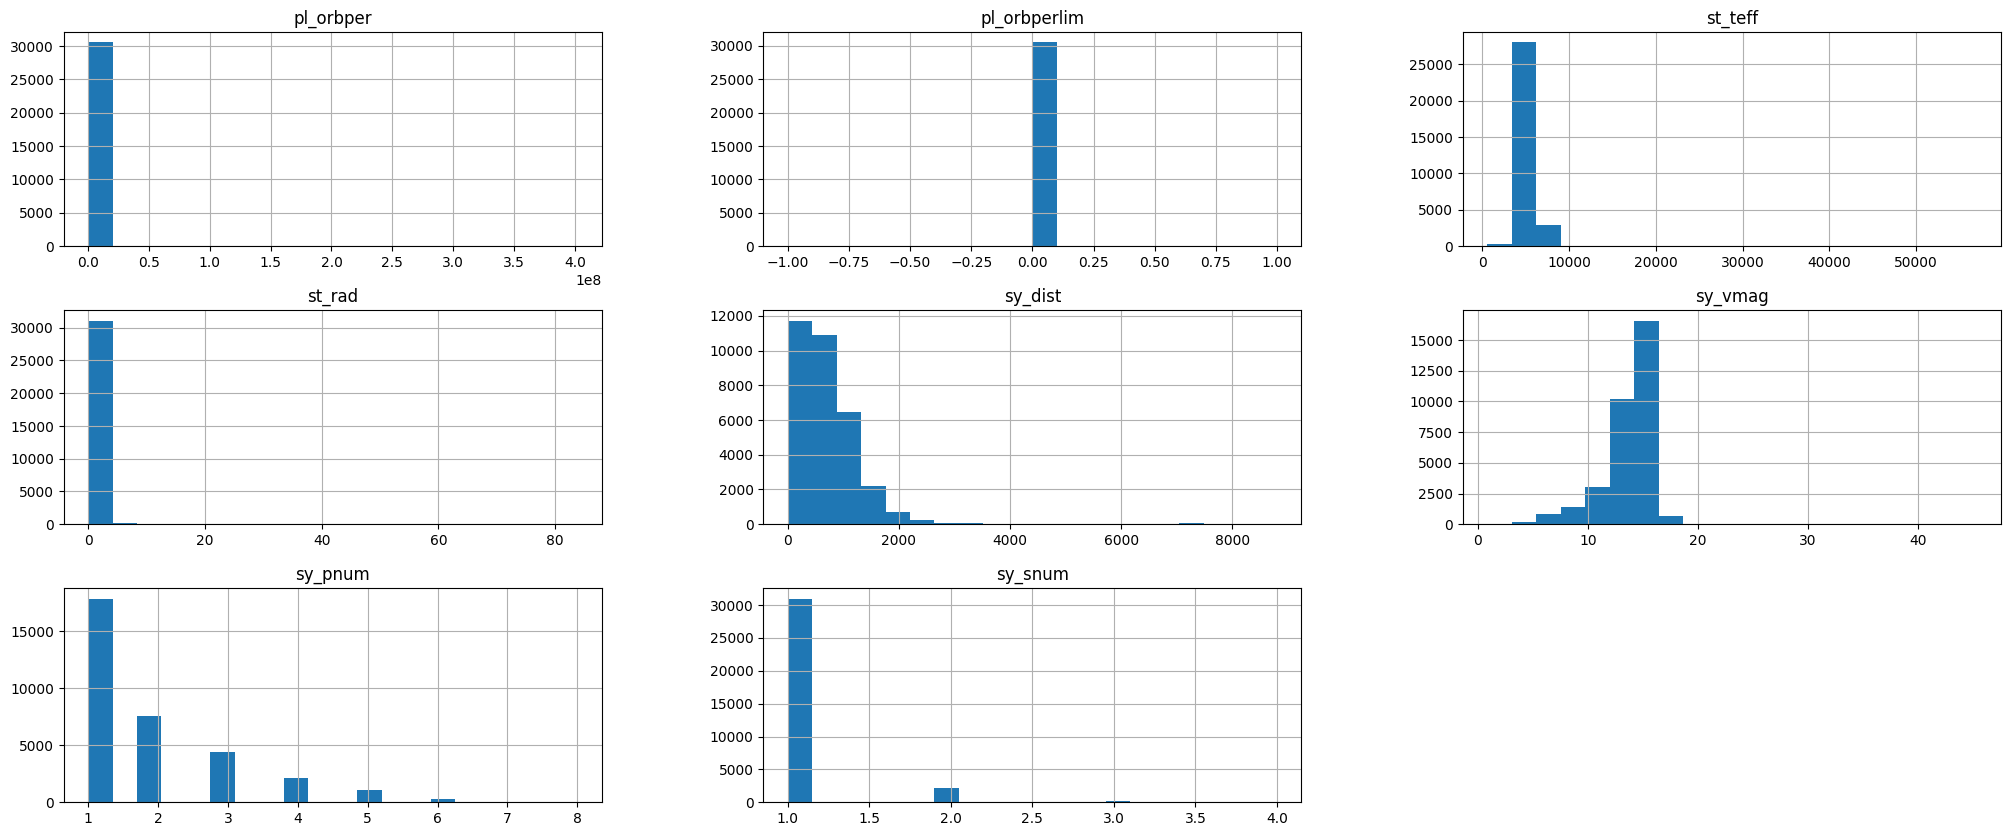

In [16]:
df.hist(column=['pl_orbper', 'pl_orbperlim', 'st_teff', 'st_rad', 'sy_dist', 'sy_vmag', 'sy_pnum', 'sy_snum'], bins=20, figsize=(25, 10))

#### This step generated some intersting takeaways. First - pl_orbper (which measures how long it takes an exoplanet to orbit its star) has some VERY acute outliers. Let's build a function to drop them from the dataset. 
##### Note: There are better ways of accomplishing this task and of writing this function. But I wanted to demo basic SQL skills at some point in this project :) 

In [17]:
def CleanOutliers (df, col):
    df[col+'_z_score']=stats.zscore(df[col], axis=0, nan_policy='omit')
    x = sqldf("SELECT pl_name," + col + ' ,' +col+"_z_score FROM df WHERE" + ' ' + col + "_z_score >= 3", globals())
    x = pd.DataFrame(x)
    outliers = x['pl_name']
    
    for outlier in outliers:
        df.drop(df.loc[df['pl_name']==outlier].index, inplace=True)
    

    return df.sort_values(by=[col], ascending=False)

In [18]:
CleanOutliers(df, 'pl_orbper')

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,pl_orbper_z_score
33257,b Cen AB b,b Cen A,1,2,1,Imaging,2021,Paranal Observatory,Published Confirmed,0,...,4.487,0.026,-0.026,4.01093,0.008918,-0.008918,1/24/2022,2021-12,1/24/2022,0.771628
3248,HR 8799 b,HR 8799,0,1,4,Imaging,2008,Gemini Observatory,Published Confirmed,0,...,5.240,0.018,-0.018,5.90914,0.001878,-0.001878,8/4/2016,2016-08,8/4/2016,0.068543
3247,HR 8799 b,HR 8799,1,1,4,Imaging,2008,Gemini Observatory,Published Confirmed,0,...,5.240,0.018,-0.018,5.90914,0.001878,-0.001878,5/14/2014,2008-11,5/14/2014,0.067819
3246,HR 8799 b,HR 8799,0,1,4,Imaging,2008,Gemini Observatory,Published Confirmed,0,...,5.240,0.018,-0.018,5.90914,0.001878,-0.001878,12/2/2015,2016-03,12/3/2015,0.066303
3251,HR 8799 c,HR 8799,0,1,4,Imaging,2008,Gemini Observatory,Published Confirmed,0,...,5.240,0.018,-0.018,5.90914,0.001878,-0.001878,12/2/2015,2016-03,12/3/2015,0.030133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33279,eps Tau b,eps Tau,0,1,1,Radial Velocity,2006,Okayama Astrophysical Observatory,Published Confirmed,0,...,1.422,0.254,-0.254,3.27298,0.004088,-0.004088,9/20/2019,2019-02,9/26/2019,NaN
33293,kap And b,kap And,0,1,1,Imaging,2012,Subaru Telescope,Published Confirmed,0,...,4.571,0.354,-0.354,4.13478,0.004153,-0.004153,5/16/2014,2013-02,5/16/2014,NaN
33294,kap And b,kap And,1,1,1,Imaging,2012,Subaru Telescope,Published Confirmed,0,...,4.571,0.354,-0.354,4.13478,0.004153,-0.004153,5/14/2014,2014-02,5/14/2014,NaN
33304,mu 2 Sco b,mu 2 Sco,1,1,1,Imaging,2022,Paranal Observatory,Published Confirmed,0,...,4.292,0.312,-0.312,3.53617,0.006949,-0.006949,6/8/2022,2022-05,6/8/2022,NaN


#### It also looks like pl_orbperlim doesn't contain a lot of information - we can check in on that quickly. 

In [19]:
print(df['pl_orbperlim'].sum())
print(df['pl_orbperlim'].value_counts())

-6.0
 0.0    30510
-1.0        9
 1.0        3
Name: pl_orbperlim, dtype: int64


#### Yikes! This attribute will be of almost no help in training a model. It won't make our final feature list. 

#### Let's get a sense of how the discovery methods are distributed.

In [20]:
df['discoverymethod'].value_counts()

Transit                          30418
Radial Velocity                   2253
Microlensing                       393
Transit Timing Variations          120
Imaging                            109
Eclipse Timing Variations           24
Orbital Brightness Modulation       20
Pulsar Timing                       12
Astrometry                           2
Pulsation Timing Variations          2
Disk Kinematics                      1
Name: discoverymethod, dtype: int64

#### With so few observations for most of the discovery methods, we'll have to pare our analysis down to the three largest - and even that's a bit of a stretch given the disparity between the third largets number of observations (393) and the largest count (30,418)

#### You can find quality descriptions of three most common methods - Transit, Radial Velocity, and Microlensing - here: https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/. For now, let's pare our data down to the area of focus.

In [21]:
too_small = ['Transit Timing Variations', 'Imaging', 'Eclipse Timing Variations', 'Orbital Brightness Modulation', 'Pulsar Timing', 'Astrometry', 'Pulsation Timing Variations', 'Disk Kinematics']

for i in too_small:
    df.drop(df.loc[df['discoverymethod']==i].index, inplace=True)
df['discoverymethod'].value_counts()

Transit            30418
Radial Velocity     2253
Microlensing         393
Name: discoverymethod, dtype: int64

## Preparing Data for Training

#### Because two of our three chosen discovery methods are severly underrepresented in our sample, we'll need to take corrective action. 

In [22]:
rus = RandomUnderSampler(sampling_strategy='majority')

#### We pick our curated list of features, and replace any nulls with the mean value

In [23]:
features = ['pl_orbper', 'st_teff', 'st_rad', 'sy_dist', 'sy_vmag', 'sy_snum', 'sy_pnum']

In [24]:
for i in features:
    x = df[i].mean()
    df[i].fillna(x, inplace=True)
glimpse = df[features]
glimpse.head()

,pl_orbper,st_teff,st_rad,sy_dist,sy_vmag,sy_snum,sy_pnum
0,326.030000,4742.000000,19.000000,93.1846,4.72307,2,1
1,128.320867,5459.854759,1.141033,93.1846,4.72307,2,1
2,516.220000,4340.000000,24.080000,125.3210,5.01300,1,1
3,128.320867,5459.854759,1.141033,125.3210,5.01300,1,1
4,516.219970,4213.000000,29.790000,125.3210,5.01300,1,1


#### We'll scale our data and solve the underrepresentation

In [25]:
X = df[features]
ss = preprocessing.StandardScaler()
X = ss.fit_transform(X)
y = df['discoverymethod']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = np.array(y_train)
x_train, y_train = rus.fit_resample(x_train, y_train)

#### Let's evalute some KNN models, with a range of ks. The code below creates an array of accuracy scores, and prints the index of the highest score and the score itself.

In [27]:
f = range(100)
scores = []
for i in f:
    knn = KNeighborsClassifier(n_neighbors=i+1)
    knn.fit(x_train, y_train)
    z = cross_val_score(knn, x_test, y_test)
    x = z.mean()
    scores.append(x)
max_value = np.argmax(scores)
print(f"The optimal k is {max_value + 1}, which has an accuracy score of {scores[max_value]}")

The optimal k is 1, which has an accuracy score of 0.9919354838709676


#### Well ... that isn't fantastic. An optimal k of 1 suggests that our solution to undersampling might not have helped a ton. If the data was NOT oversampled, we'd expect a larger k to be the best predictor, indicating that our various data points were somewhat evenly distributed throughout the hypothetical space. But we'll keep plugging away, just to be sure.

#### We can also visualize the relationship between the size of k and the model's accuracy.

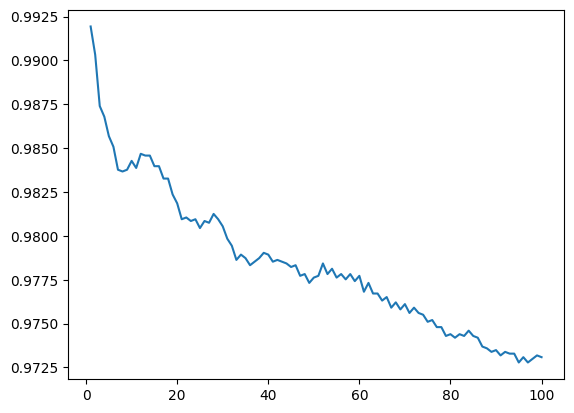

In [28]:
f = range(1, 101, 1)
fig = plt.plot(f, scores)
fig

In [29]:
knn = KNeighborsClassifier(n_neighbors=max_value+1)
knn.fit(x_train, y_train)
y_hat = knn.predict(x_test)

#### With an optimal k selected, we'll examine at a confusion matrix of the results and look for any patterns.  

[Text(0, 0.5, 'Microlensing'),
 Text(0, 1.5, 'Radial Velocity'),
 Text(0, 2.5, 'Transit')]

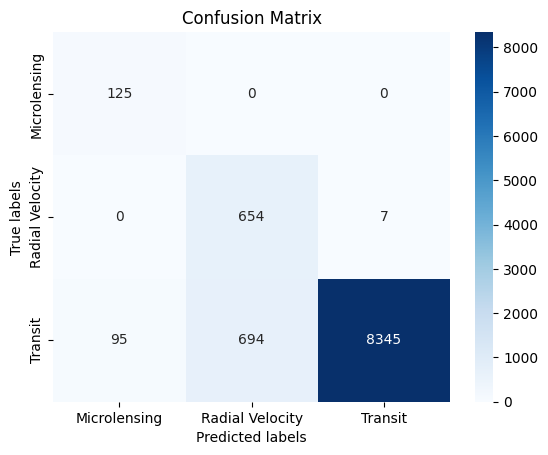

In [30]:
cm = confusion_matrix(y_test, y_hat)

ax= plt.subplot()
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Microlensing', 'Radial Velocity', 'Transit']); ax.yaxis.set_ticklabels(['Microlensing', 'Radial Velocity', 'Transit'])

#### Ok - so it seems that the model does a respectable job of accurately classifying the test data. The model's performance could indicate that the three most common discovery methods tend to pick up only exoplanets with certain charecteristics - e.g., a certain radius or mass. That isn't to say the methods are unreliable, but rather that applying only one of the three methods to a given area of space may be inadequate for discovering all of the exoplanets in that area.

#### HOWEVER-

#### We're still left with our concerns about the fact that k=1 is the best hyperparameter. It seems to force the model to overally-aggressively classify a discovery method as 'Transit'. In fact, more than 85% all of its 'misses' were such incorrect classifications. That fact indicates that, despite re-weighting our data to account for underweight samples, the ubiquity of the Transit discovery method still affects the model's performance. 

## Conclusion

#### And that's that! We've gained an interesting insight from our data - even though we need to figure out potential undersmapling problems. To close, let's glance at a cool visualization of where our exoplanets are located in the Milky Way. 

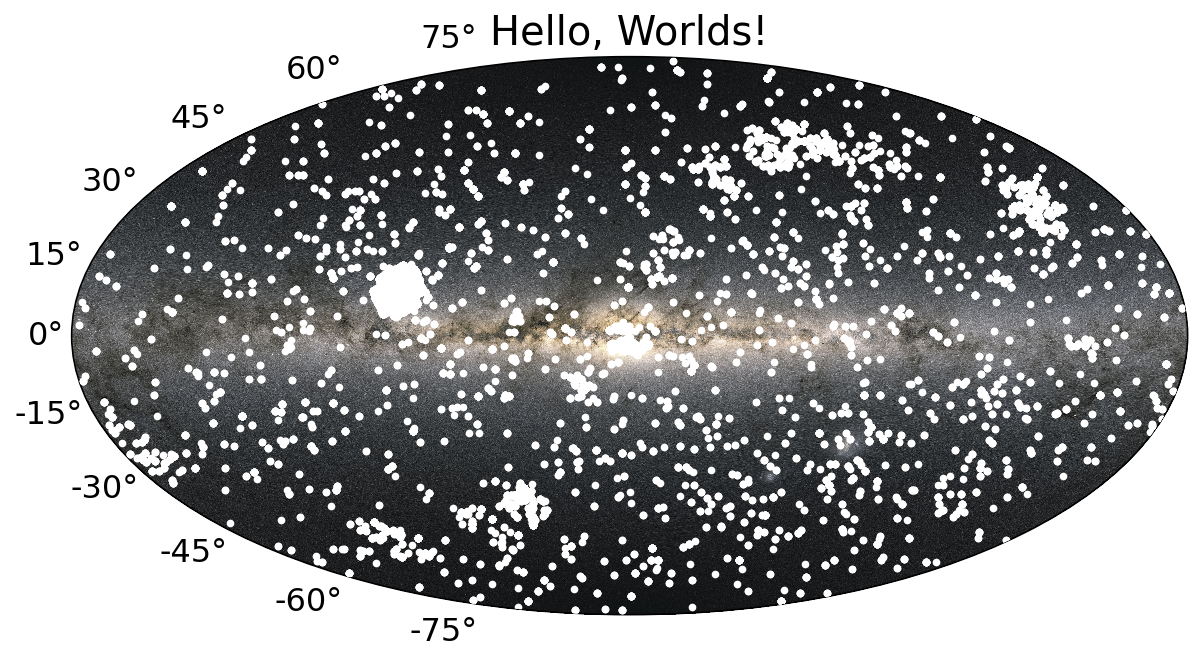

In [31]:
mw1 = MWSkyMap(projection='aitoff', grayscale=False)
mw1.title = 'Hello, Worlds!'
ra = np.array(df['ra'])
dec = np.array(df['dec'])
ra = ra * u.degree
dec = dec * u.degree

mw1.scatter(ra, dec, c='w', s=8)